In [1]:
## Python in build modules:
import os
import re
from collections import Counter
import time

## EDA libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## Metrics (sklearn)
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score

## Models (sklearn)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, KFold
from sklearn.pipeline import make_pipeline

In [2]:
def print_report(y_true, prediction):
    print('Confusion Matrix')
    print(confusion_matrix(y_true, prediction))
    print("\n")
    print('Classification Report')
    print(classification_report(y_true, prediction))
    print("\n")
    print("Other Metrics:")
    print(f'Pression Score: {precision_score(y_true, prediction)}')
    print(f'Accuracy Score: {accuracy_score(y_true, prediction)}')
    print(f'Recall Score: {recall_score(y_true, prediction)}')
    print(f'f1 Score {f1_score(y_true, prediction)}')
    
def check_model(clf, X_test, y_test):
    prediction = clf.predict(X_test)
    print_report(y_test, prediction)
    
def vectorize_X(vectorizer, X_train, X_test):
    X_train_vectorized = vectorizer.fit_transform(X_train)
    X_test_vectorized  = vectorizer.transform(X_test)
    return X_train_vectorized, X_test_vectorized

### 1) Exploratory Analysis

In [3]:
## Importing the data

path = 'data/train/'

count = 0
labels = []
contents = []

for label in ['neg','pos']:
    filenames = os.listdir(path + label)
    for filename in filenames:
        count += 1
        with open(os.path.join(path, label, filename), 'r') as f:
            labels.append(1 if label == 'pos' else 0) # 1 is positve 0 is negative
            contents.append(f.read())
print(count)
            
data = pd.DataFrame({
    'contents' : contents,
    'labels': labels,

})

data = data.sample(frac=1, random_state=42).reset_index(drop=True) # This code will shuffle the data (just in case!)

25000


#### Just to be clear negative is 0 and positive is 1

In [4]:
data.labels.value_counts()

0    12500
1    12500
Name: labels, dtype: int64

Ok, the data is **completely balanced**.

 ###### At this moment we are going to see 5 examples of each column

In [5]:
for label in data.labels.unique():
    print("negative" if label ==  0 else "positive")
    print("\n")
    for content in data.contents[data.labels == label].sample(2):
        print(content)
        print("\n")

negative


Seriously, I'm all for gooey romantic comedies and will get sucked into Miss Congeniality as easily as Goodfellas...but this movie? It doesn't make any sense!!!! And I'm not even talking about the willing suspension of disbelief kind of not making sense. Why does her family live in England? Or, at the very least, why doesn't she have a British accent? She's sure cozy with her dad and he's surprisingly forgiving of her not being around for the last two years. (On that subject, no one ever makes much of a deal about her being away for so long). And what was with the goofy outfits at the bachelorette party? I'm not even going to get into the fact that the escort she paid for falls in love with her--that could've been overcome by better movie-making. I'm just saying that the characters, the setting, and the plot aren't fleshed out enough to make an even somewhat cohesive story. Oh, and the worst part, in my opinion, is the filmmaker's consistent use of the most unflattering angl

###### From now on I am going to be using the training data to explore the data so I can get some conclusions.

In [6]:
X = data.contents
y = data.labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [7]:
train_df = pd.concat([X_train, y_train],axis=1)

In [8]:
train_df.labels.value_counts() # Just checking the proportions haven't change much

1    8387
0    8363
Name: labels, dtype: int64

### Does it has to do something with length?

###### Mean of length

In [9]:
mean_length_full = np.round(X_train.map(len).mean(),2)
train_df = pd.concat([X_train, y_train], axis=1)
mean_lenght_pos = train_df[train_df.labels == 1].contents.map(len).mean()
mean_length_neg = train_df[train_df.labels == 0].contents.map(len).mean()
ratio_pos =  mean_lenght_pos / mean_length_full
ratio_neg =  mean_length_neg / mean_length_full

print(f'Mean length of all reviews: {mean_length_full}')
print(f'Mean length in positive reviews: {mean_lenght_pos}')
print(f'Mean length in negative reviews: {mean_length_neg}')
print(f'Ratio positive: {ratio_pos}')
print(f'Ration negative: {ratio_neg}')

Mean length of all reviews: 1328.28
Mean length in positive reviews: 1352.3945391677596
Mean length in negative reviews: 1304.1033122085375
Ratio positive: 1.0181547107294844
Ration negative: 0.9817985004731966


We can run an **A/B test** here, but there is an indication that the **length** of the commentary has **nothing to do** with the idea if it is positive or negative.

###### Describing of length

In [10]:
print('Describe the length of model when positive:')
print(train_df[train_df.labels == 1].contents.map(len).describe())
print('\n')
print('Describe the length of model when negative:')
print(train_df[train_df.labels == 0].contents.map(len).describe())

Describe the length of model when positive:
count     8387.000000
mean      1352.394539
std       1053.673512
min         70.000000
25%        695.000000
50%        982.000000
75%       1659.500000
max      13704.000000
Name: contents, dtype: float64


Describe the length of model when negative:
count    8363.000000
mean     1304.103312
std       963.063593
min        53.000000
25%       710.000000
50%       981.000000
75%      1554.000000
max      8754.000000
Name: contents, dtype: float64


In [11]:
for i in range(80,101,4):
    print(f'percentage: {i}')
    print('positive')
    print(np.percentile(train_df[train_df.labels == 1].contents.map(len), i))
    print('negative')
    print(np.percentile(train_df[train_df.labels == 0].contents.map(len), i))

percentage: 80
positive
1917.0
negative
1799.0
percentage: 84
positive
2168.7199999999993
negative
2015.0
percentage: 88
positive
2514.0
negative
2328.120000000001
percentage: 92
positive
3005.0
negative
2755.12
percentage: 96
positive
3815.119999999999
negative
3521.079999999998
percentage: 100
positive
13704.0
negative
8754.0


###### Doesn't seem likely. We can see there is a little divergence when the comments start to get longer that people with good reviews will tend to write longer comments. #trustinhumanityrestored (not really)

### What about number of paragraphs?

In [12]:
def count_paragraph(x):
    return x.count('<br /><br />') + 1

In [13]:
paragraphs = pd.concat([train_df.contents.apply(count_paragraph), train_df.labels],axis=1)

In [14]:
print('Describe the n parragraphs of model when positive:')
print(paragraphs[paragraphs.labels == 1].contents.describe())
print('\n')
print('Describe the n parragraphs of model when negative:')
print(paragraphs[paragraphs.labels == 0].contents.describe())

Describe the n parragraphs of model when positive:
count    8387.000000
mean        2.972696
std         2.518918
min         1.000000
25%         1.000000
50%         2.000000
75%         4.000000
max        26.000000
Name: contents, dtype: float64


Describe the n parragraphs of model when negative:
count    8363.000000
mean        3.116705
std         2.797950
min         1.000000
25%         1.000000
50%         2.000000
75%         4.000000
max        47.000000
Name: contents, dtype: float64


In [15]:
for i in range(80,101,4):
    print(f'percentage: {i}')
    print('positive')
    print(np.percentile(paragraphs[paragraphs.labels == 1].contents, i))
    print('negative')
    print(np.percentile(paragraphs[paragraphs.labels == 0].contents , i))

percentage: 80
positive
5.0
negative
5.0
percentage: 84
positive
5.0
negative
5.0
percentage: 88
positive
6.0
negative
6.0
percentage: 92
positive
7.0
negative
7.0
percentage: 96
positive
8.0
negative
8.0
percentage: 100
positive
26.0
negative
47.0


###### Doesn't seem likely.  There are cases that are outliers but nothing really there.

In [16]:
## We can actually look for the outliers.

### What about complexity and readiability?

###### Flesch ease

In [17]:
def FleschReadabilityEase(text):
    if len(text) > 0:
        total_words = len(text.split())
        total_sentences = len(text.split('.'))
        total_sillables = sum(list(map(lambda x: 1 if x in ["a","i","e","o","u","y","A","E","I","O","U","y"] else 0, text)))
        return 206.835 - (1.015 *  total_words/ total_sentences) - 84.6 * (total_sillables / total_words)

In [18]:
flesch_ease = train_df.contents.map(FleschReadabilityEase)
flesch_ease = pd.concat([train_df, flesch_ease], axis=1)
flesch_ease.columns = ['contents', 'labels', 'ease']

In [19]:
flesch_ease

,contents,labels,ease
12131,Ernst Lubitsch's contribution to the American ...,1,40.428436
12827,The name (Frau) of the main character is the G...,0,40.173923
2912,"Upon The Straight Story release in 1999, it wa...",1,34.813930
13762,This documentary explores a story covered in P...,1,23.340646
6369,"Tho 35 years old, Groove Tube looks a lot like...",1,-3.854812
...,...,...,...
21575,"Yes, Kazaam is one of those horribly bad movie...",0,35.520517
5390,The 3rd and in my view the best of the Blackad...,1,39.070429
860,!!!!! POSSIBLE SPOILER !!!!!<br /><br />You`d ...,0,29.169732
15795,I cant understand at all why so many Godzilla ...,0,25.185830


In [20]:
print('Describe the ease of model when positive:')
print(flesch_ease[flesch_ease.labels == 1].ease.describe())
print('\n')
print('Describe the ease of model when negative:')
print(flesch_ease[flesch_ease.labels == 0].ease.describe())

Describe the ease of model when positive:
count    8387.000000
mean       38.949473
std        14.656158
min      -134.725000
25%        30.794855
50%        39.755331
75%        48.474976
max        85.408412
Name: ease, dtype: float64


Describe the ease of model when negative:
count    8363.000000
mean       41.710220
std        16.602777
min      -337.909000
25%        34.047744
50%        42.679525
75%        51.194469
max       103.367105
Name: ease, dtype: float64


In [21]:
for i in range(80,101,4):
    print(f'percentage: {i}')
    print('positive')
    print(np.percentile(flesch_ease[flesch_ease.labels == 1].ease, i))
    print('negative')
    print(np.percentile(flesch_ease[flesch_ease.labels == 0].ease, i))

percentage: 80
positive
50.54745520133298
negative
53.188188158577596
percentage: 84
positive
52.426362848962086
negative
55.0011225702047
percentage: 88
positive
54.443156091257045
negative
56.96770877192985
percentage: 92
positive
57.18548441708349
negative
59.651001063020445
percentage: 96
positive
61.48505739004381
negative
63.615432606322905
percentage: 100
positive
85.4084121621622
negative
103.36710526315791


###### The difference in complexity is not crazy, but is there (at least for this model) . Can we use this knowledge in some sort of way? The process is also a little bit memory consuming.

##### There are outliers also outliers

In [22]:
## Outliers of low understandability
flesch_ease[flesch_ease.ease < -0].contents.sample(1).iloc[0]

'This, the finest achievement from Georg Wilhelm Pabst\'s Social Realism period is based upon a tragedy in early 1906 that claimed the lives of nearly 1100 French miners as a coal dust explosion deep in mines at Courrieres in northern France took place after a fire had smouldered for three weeks, eventually releasing deadly pit gas that brought about the fatalities. Estimable designer Erno Metzner creates stark sets that simulate the tragedy, providing a perception of reality, augmented by matchless sound editing, with the only music being produced by integral orchestras during the beginning and ending portions of a work for which aural effects possess equal importance with the eminent director\'s fascinating visual compositions. Pabst\'s manner of "invisible editing" that segues action from shot to shot through movements of players proves to be smoothly integrated within this landmark film that also showcases sublime cinematography utilizing cameras mounted upon vehicles, enabling the

In [23]:
## There are reviews that make little sense

In [24]:
len(flesch_ease[flesch_ease.ease < -0])

155

In [25]:
## Outliers of high understandability
flesch_ease[flesch_ease.ease > 80].contents.sample(1).iloc[0]

"i just saw this movie on TV..<br /><br />i've lost my dad when i was young and this movie surely did touch me..<br /><br />i can feel the lost that the little girl Desi felt..<br /><br />the feeling of wanting to see her father again..<br /><br />wanting to talk to him..<br /><br />or at least given the chance to say goodbye..<br /><br />and i'm so touched with the letter that was wrote back to her..<br /><br />saying that her father read her letter, and sent it back to someone to reply her and buy her a present because there isn't a shop in heaven..<br /><br />it just lets me feel that miracles do exist.."

In [26]:
len(flesch_ease[flesch_ease.ease > 80])

21

In [27]:
flesch_ease

,contents,labels,ease
12131,Ernst Lubitsch's contribution to the American ...,1,40.428436
12827,The name (Frau) of the main character is the G...,0,40.173923
2912,"Upon The Straight Story release in 1999, it wa...",1,34.813930
13762,This documentary explores a story covered in P...,1,23.340646
6369,"Tho 35 years old, Groove Tube looks a lot like...",1,-3.854812
...,...,...,...
21575,"Yes, Kazaam is one of those horribly bad movie...",0,35.520517
5390,The 3rd and in my view the best of the Blackad...,1,39.070429
860,!!!!! POSSIBLE SPOILER !!!!!<br /><br />You`d ...,0,29.169732
15795,I cant understand at all why so many Godzilla ...,0,25.185830


###### So how is the data distributed?

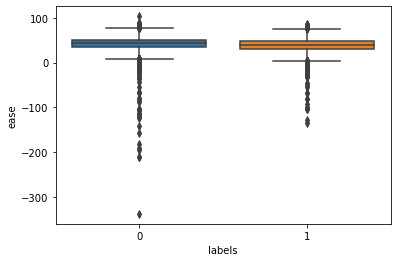

In [28]:
ax = sns.boxplot(x="labels", y="ease",
                    data=flesch_ease)

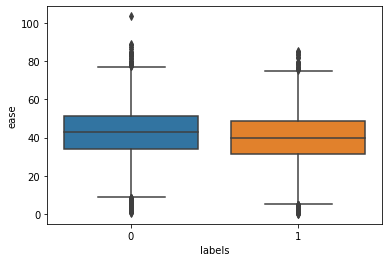

In [29]:
ax = sns.boxplot(x="labels", y="ease",
                    data=flesch_ease[flesch_ease.ease > 0])

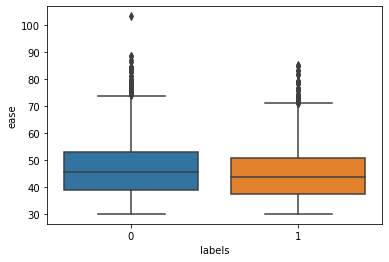

In [30]:
ax = sns.boxplot(x="labels", y="ease",
                    data=flesch_ease[flesch_ease.ease > 30])

###### There is a difference but not that much, when you take outliers positive reviews are just a bit harder to read. At least in this model

###### Most common word for each label

In [34]:
## Most common words in general

cv = CountVectorizer(stop_words={'english'})
list_of_words = cv.fit_transform(X_train).toarray()
sum_of_words = pd.Series(list_of_words.sum(axis=0))
sum_of_words = sum_of_words.sort_values(ascending=False)[:20]

words = []
numbers = []

for num in sum_of_words.index:
    word = (list(cv.vocabulary_.keys())[list(cv.vocabulary_.values()).index(num)])
    numbers.append(sum_of_words.loc[num])
    words.append(word)
    
pd.DataFrame({
    "words" : words,
    "counts" : numbers,
})

,words,counts
0,the,226374
1,and,110239
2,of,97692
3,to,91327
4,is,72318
5,br,68495
6,it,65011
7,in,62845
8,this,50974
9,that,49116


In [35]:
pos_X_train = train_df.contents[train_df.labels == 1]

cv = CountVectorizer(stop_words={'english'}, ngram_range=(1,1))
list_of_words = cv.fit_transform(pos_X_train).toarray()
sum_of_words = pd.Series(list_of_words.sum(axis=0))
sum_of_words = sum_of_words.sort_values(ascending=False)[:20]

words = []
numbers = []

for num in sum_of_words.index:
    word = (list(cv.vocabulary_.keys())[list(cv.vocabulary_.values()).index(num)])
    numbers.append(sum_of_words.loc[num])
    words.append(word)
    
pd.DataFrame({
    "words" : words,
    "counts" : numbers,
})

,words,counts
0,the,116902
1,and,60296
2,of,51458
3,to,45150
4,is,38653
5,in,33731
6,br,33091
7,it,32486
8,that,23998
9,this,23519


In [36]:
neg_X_train = train_df.contents[train_df.labels == 0]

cv = CountVectorizer(stop_words={'english'})
list_of_words = cv.fit_transform(pos_X_train).toarray()
sum_of_words = pd.Series(list_of_words.sum(axis=0))
sum_of_words = sum_of_words.sort_values(ascending=False)[:20]

words = []
numbers = []

for num in sum_of_words.index:
    word = (list(cv.vocabulary_.keys())[list(cv.vocabulary_.values()).index(num)])
    numbers.append(sum_of_words.loc[num])
    words.append(word)
    
pd.DataFrame({
    "words" : words,
    "counts" : numbers,
})

,words,counts
0,the,116902
1,and,60296
2,of,51458
3,to,45150
4,is,38653
5,in,33731
6,br,33091
7,it,32486
8,that,23998
9,this,23519


#### 2) Removing stop words

In [138]:
neg_X_train = train_df.contents[train_df.labels == 0]

cv = CountVectorizer(stop_words={'english'}, max_df=.2)
list_of_words = cv.fit_transform(pos_X_train).toarray()
sum_of_words = pd.Series(list_of_words.sum(axis=0))
sum_of_words = sum_of_words.sort_values(ascending=False)[:20]

words = []
numbers = []

for num in sum_of_words.index:
    word = (list(cv.vocabulary_.keys())[list(cv.vocabulary_.values()).index(num)])
    numbers.append(sum_of_words.loc[num])
    words.append(word)
    
df1 = pd.DataFrame({
    "words" : words,
    "counts" : numbers,
})



pos_X_train = train_df.contents[train_df.labels == 1]

cv = CountVectorizer(stop_words={'english'}, max_df=.2)
list_of_words = cv.fit_transform(pos_X_train).toarray()
sum_of_words = pd.Series(list_of_words.sum(axis=0))
sum_of_words = sum_of_words.sort_values(ascending=False)[:20]

words = []
numbers = []

for num in sum_of_words.index:
    word = (list(cv.vocabulary_.keys())[list(cv.vocabulary_.values()).index(num)])
    numbers.append(sum_of_words.loc[num])
    words.append(word)
    
df2 = pd.DataFrame({
    "words" : words,
    "counts" : numbers,
})

pd.concat([df1,df2], axis=1)

,words,counts,words,counts
0,films,2526,films,2526
1,character,2386,character,2386
2,movies,2382,movies,2382
3,characters,2341,characters,2341
4,man,2330,man,2330
5,then,2308,then,2308
6,show,2308,show,2308
7,little,2182,little,2182
8,where,2174,where,2174
9,could,2152,could,2152


### 2) Running the first models

#### Model number 1

In [38]:
mnb = MultinomialNB()
cv = CountVectorizer(stop_words='english')

for cv ,clf, clf_name in [(vec , mnb, 'Multinomial Naive Bayes')]:
    # Vectorization
    start = time.process_time()
    X_train_vectorized, X_test_vectorized = vectorize_X(vec, X_train, X_test)
    print('The amount of features in the Vectorized X train is: {:,} '.format(X_train_vectorized.shape[1]))
    print(f'The amount of time it took to vectorize was: {time.process_time() - start}\n')
    
    # Running the model
    print(clf_name)
    clf.fit(X_train_vectorized, y_train)
    check_model(clf, X_test_vectorized, y_test)
    print("_________________________________________________")

The amount of features in the Vectorized X train is: 3,718,004 
The amount of time it took to vectorize was: 17.154719999999998

Multinomial Naive Bayes
Confusion Matrix
[[3751  386]
 [ 530 3583]]


Classification Report
              precision    recall  f1-score   support

           0       0.88      0.91      0.89      4137
           1       0.90      0.87      0.89      4113

    accuracy                           0.89      8250
   macro avg       0.89      0.89      0.89      8250
weighted avg       0.89      0.89      0.89      8250



Other Metrics:
Pression Score: 0.9027462836986646
Accuracy Score: 0.888969696969697
Recall Score: 0.8711402868952103
f1 Score 0.886661717396684
_________________________________________________


This is the base Multinominal only using basic stop words in english. It is using a basic ngram_range of 1,1. 

#### Model number 2

In [55]:
mnb = MultinomialNB()
cv = CountVectorizer(stop_words='english', ngram_range=(1,3))

for vec ,clf, clf_name in [(cv , mnb, 'Multinomial Naive Bayes')]:
    
    # Vectorization
    start = time.process_time()
    X_train_vectorized, X_test_vectorized = vectorize_X(vec, X_train, X_test)
    print('The amount of features in the Vectorized X train is: {:,} '.format(X_train_vectorized.shape[1]))
    print(f'The amount of time it took to vectorize was: {time.process_time() - start}\n')
    
    # Running the model
    print(clf_name)
    clf.fit(X_train_vectorized, y_train)
    check_model(clf, X_test_vectorized, y_test)
    print("_________________________________________________")

The amount of features in the Vectorized X train is: 2,991,762 
The amount of time it took to vectorize was: 13.267948000000004

Multinomial Naive Bayes
Confusion Matrix
[[3663  474]
 [ 545 3568]]


Classification Report
              precision    recall  f1-score   support

           0       0.87      0.89      0.88      4137
           1       0.88      0.87      0.88      4113

    accuracy                           0.88      8250
   macro avg       0.88      0.88      0.88      8250
weighted avg       0.88      0.88      0.88      8250



Other Metrics:
Pression Score: 0.8827313211281543
Accuracy Score: 0.8764848484848485
Recall Score: 0.8674933138828106
f1 Score 0.8750459840588596
_________________________________________________


The second model performs better, specially in recall. However it takes too much time to perform.

In [ ]:
#### Model number 3

In [63]:
mnb = MultinomialNB()
cv = CountVectorizer(stop_words='english', ngram_range=(1, 3))
X_train_sample = X_train.sample(frac=.8, random_state=50)
y_train_sample = y_train.sample(frac=.8, random_state=50)

for vec ,clf, clf_name in [(cv , mnb, 'Multinomial Naive Bayes')]:
    
    # Vectorization
    start = time.process_time()
    X_train_vectorized, X_test_vectorized = vectorize_X(vec, X_train_sample, X_test)
    print('The amount of features in the Vectorized X train is: {:,} '.format(X_train_vectorized.shape[1]))
    print(f'The amount of time it took to vectorize was: {time.process_time() - start}\n')
    
    # Running the model
    print(clf_name)
    clf.fit(X_train_vectorized, y_train_sample)
    check_model(clf, X_test_vectorized, y_test)
    print("_________________________________________________")

The amount of features in the Vectorized X train is: 2,441,663 
The amount of time it took to vectorize was: 10.759179000000017

Multinomial Naive Bayes
Confusion Matrix
[[3653  484]
 [ 550 3563]]


Classification Report
              precision    recall  f1-score   support

           0       0.87      0.88      0.88      4137
           1       0.88      0.87      0.87      4113

    accuracy                           0.87      8250
   macro avg       0.87      0.87      0.87      8250
weighted avg       0.87      0.87      0.87      8250



Other Metrics:
Pression Score: 0.8804052384482333
Accuracy Score: 0.8746666666666667
Recall Score: 0.8662776562120107
f1 Score 0.8732843137254902
_________________________________________________


Feeding the model with less amount of data; seems to make the model run worse, which was expected. I need to check with an a/b testing though.

#### Model number 4

In [64]:
mnb = MultinomialNB()
cv = CountVectorizer(stop_words='english', ngram_range=(1,5))

for vec ,clf, clf_name in [(cv , mnb, 'Multinomial Naive Bayes')]:
    
    # Vectorization
    start = time.process_time()
    X_train_vectorized, X_test_vectorized = vectorize_X(vec, X_train_sample, X_test)
    print('The amount of features in the Vectorized X train is: {:,} '.format(X_train_vectorized.shape[1]))
    print(f'The amount of time it took to vectorize was: {time.process_time() - start}\n')
    
    # Running the model
    print(clf_name)
    clf.fit(X_train_vectorized, y_train_sample)
    check_model(clf, X_test_vectorized, y_test)
    print("_________________________________________________")

The amount of features in the Vectorized X train is: 5,342,619 
The amount of time it took to vectorize was: 21.06203400000001

Multinomial Naive Bayes
Confusion Matrix
[[3643  494]
 [ 527 3586]]


Classification Report
              precision    recall  f1-score   support

           0       0.87      0.88      0.88      4137
           1       0.88      0.87      0.88      4113

    accuracy                           0.88      8250
   macro avg       0.88      0.88      0.88      8250
weighted avg       0.88      0.88      0.88      8250



Other Metrics:
Pression Score: 0.878921568627451
Accuracy Score: 0.8762424242424243
Recall Score: 0.8718696814976903
f1 Score 0.8753814231661174
_________________________________________________


#### Model number 5

In [40]:
mnb = MultinomialNB()
stop_words = 'the and of to is in br it that this as with for was film movie his on are have be one'.split(' ')
cv = CountVectorizer(stop_words=stop_words, ngram_range=(1,3))

for cv ,clf, clf_name in [(vec , mnb, 'Multinomial Naive Bayes')]:
    # Vectorization
    start = time.process_time()
    X_train_vectorized, X_test_vectorized = vectorize_X(vec, X_train, X_test)
    print('The amount of features in the Vectorized X train is: {:,} '.format(X_train_vectorized.shape[1]))
    print(f'The amount of time it took to vectorize was: {time.process_time() - start}\n')
    
    # Running the model
    print(clf_name)
    clf.fit(X_train_vectorized, y_train)
    check_model(clf, X_test_vectorized, y_test)
    print("_________________________________________________")

The amount of features in the Vectorized X train is: 3,718,004 
The amount of time it took to vectorize was: 16.878854000000004

Multinomial Naive Bayes
Confusion Matrix
[[3751  386]
 [ 530 3583]]


Classification Report
              precision    recall  f1-score   support

           0       0.88      0.91      0.89      4137
           1       0.90      0.87      0.89      4113

    accuracy                           0.89      8250
   macro avg       0.89      0.89      0.89      8250
weighted avg       0.89      0.89      0.89      8250



Other Metrics:
Pression Score: 0.9027462836986646
Accuracy Score: 0.888969696969697
Recall Score: 0.8711402868952103
f1 Score 0.886661717396684
_________________________________________________


This was a mechanical way to extract words but I have an idea of how to authomate the process.

### 3) Tweeking Parameters

#### Max df

Max_df and min_df are use to eliminate words based on some threshold. The idea is that some tokens instead of helping
the model are only noise.
<br>There are two basic approaches to handle this types of words. We can eliminate very common words(using **max_df**) or we can eliminate very rare words using min_df.
<br><br> The idea with max_df is that if a word appears at least in a certain percentage of the sample then it should be removed.
<br><br> The idea with min_df is that if a word appears in less document that in the theshold it should be ignored. 
<br><br> Notice that max_df will have a lot of overlapping with stopwords.

In [45]:
for i in range(4,11,1):
    count_vectorizer = CountVectorizer(stop_words={'english'}, ngram_range=(1,3), max_df=i/10)
    X_train_vectorized = count_vectorizer.fit_transform(X_train)
    print(f'This is the shape for {i/10}')
    print(X_train_vectorized.shape)

This is the shape for 0.4
(16750, 3713413)
This is the shape for 0.5
(16750, 3713428)
This is the shape for 0.6
(16750, 3713440)
This is the shape for 0.7
(16750, 3713446)
This is the shape for 0.8
(16750, 3713448)
This is the shape for 0.9
(16750, 3713452)
This is the shape for 1.0
(16750, 3713457)


In [44]:
for i in range(4,11,1):
    count_vectorizer = CountVectorizer(stop_words={'english'}, ngram_range=(1,1), max_df=i/10)
    X_train_vectorized = count_vectorizer.fit_transform(X_train)
    print(f'This is the shape for {i/10}')
    print(X_train_vectorized.shape)

This is the shape for 0.4
(16750, 63655)
This is the shape for 0.5
(16750, 63670)
This is the shape for 0.6
(16750, 63680)
This is the shape for 0.7
(16750, 63685)
This is the shape for 0.8
(16750, 63687)
This is the shape for 0.9
(16750, 63691)
This is the shape for 1.0
(16750, 63696)


I don't see much of a difference in this max_df, even at really low percentages. But, never know if this can really affect the model.

In [46]:
## Most common words in general

cv = CountVectorizer(stop_words={'english'}, ngram_range=(1,1), max_df=.2)
list_of_words = cv.fit_transform(X_train).toarray()
sum_of_words = pd.Series(list_of_words.sum(axis=0))
sum_of_words = sum_of_words.sort_values(ascending=False)[:20]

words = []
numbers = []

for num in sum_of_words.index:
    word = (list(cv.vocabulary_.keys())[list(cv.vocabulary_.values()).index(num)])
    numbers.append(sum_of_words.loc[num])
    words.append(word)
    
pd.DataFrame({
    "words" : words,
    "counts" : numbers,
})

,words,counts
0,character,4746
1,films,4627
2,life,4399
3,where,4350
4,plot,4349
5,little,4309
6,show,4296
7,love,4287
8,over,4270
9,best,4199


#### Model number 1

In [47]:
mnb = MultinomialNB()
cv = CountVectorizer(stop_words={'english'}, ngram_range=(1,3), max_df=.2 )

for cv ,clf, clf_name in [(vec , mnb, 'Multinomial Naive Bayes')]:
    # Vectorization
    start = time.process_time()
    X_train_vectorized, X_test_vectorized = vectorize_X(vec, X_train, X_test)
    print('The amount of features in the Vectorized X train is: {:,} '.format(X_train_vectorized.shape[1]))
    print(f'The amount of time it took to vectorize was: {time.process_time() - start}\n')
    
    # Running the model
    print(clf_name)
    clf.fit(X_train_vectorized, y_train)
    check_model(clf, X_test_vectorized, y_test)
    print("_________________________________________________")

The amount of features in the Vectorized X train is: 3,718,004 
The amount of time it took to vectorize was: 18.143799

Multinomial Naive Bayes
Confusion Matrix
[[3751  386]
 [ 530 3583]]


Classification Report
              precision    recall  f1-score   support

           0       0.88      0.91      0.89      4137
           1       0.90      0.87      0.89      4113

    accuracy                           0.89      8250
   macro avg       0.89      0.89      0.89      8250
weighted avg       0.89      0.89      0.89      8250



Other Metrics:
Pression Score: 0.9027462836986646
Accuracy Score: 0.888969696969697
Recall Score: 0.8711402868952103
f1 Score 0.886661717396684
_________________________________________________


In [48]:
mnb = MultinomialNB()
cv = CountVectorizer(stop_words={'english'}, ngram_range=(1,3), max_df=.3)

for cv ,clf, clf_name in [(vec , mnb, 'Multinomial Naive Bayes')]:
    # Vectorization
    start = time.process_time()
    X_train_vectorized, X_test_vectorized = vectorize_X(vec, X_train, X_test)
    print('The amount of features in the Vectorized X train is: {:,} '.format(X_train_vectorized.shape[1]))
    print(f'The amount of time it took to vectorize was: {time.process_time() - start}\n')
    
    # Running the model
    print(clf_name)
    clf.fit(X_train_vectorized, y_train)
    check_model(clf, X_test_vectorized, y_test)
    print("_________________________________________________")

The amount of features in the Vectorized X train is: 3,718,004 
The amount of time it took to vectorize was: 17.942894000000024

Multinomial Naive Bayes
Confusion Matrix
[[3751  386]
 [ 530 3583]]


Classification Report
              precision    recall  f1-score   support

           0       0.88      0.91      0.89      4137
           1       0.90      0.87      0.89      4113

    accuracy                           0.89      8250
   macro avg       0.89      0.89      0.89      8250
weighted avg       0.89      0.89      0.89      8250



Other Metrics:
Pression Score: 0.9027462836986646
Accuracy Score: 0.888969696969697
Recall Score: 0.8711402868952103
f1 Score 0.886661717396684
_________________________________________________


This models perform quiet similar to the models that where run with the decided stop_words (which was expected)

#### Model number 3

In [49]:
mnb = MultinomialNB()
stop_words = 'the and of to is in br it that this as with for was film movie his on are have be one'.split(' ')
cv = CountVectorizer(stop_words=stop_words, ngram_range=(1,3), max_df=.3)


for cv ,clf, clf_name in [(vec , mnb, 'Multinomial Naive Bayes')]:
    # Vectorization
    start = time.process_time()
    X_train_vectorized, X_test_vectorized = vectorize_X(vec, X_train, X_test)
    print('The amount of features in the Vectorized X train is: {:,} '.format(X_train_vectorized.shape[1]))
    print(f'The amount of time it took to vectorize was: {time.process_time() - start}\n')
    
    # Running the model
    print(clf_name)
    clf.fit(X_train_vectorized, y_train)
    check_model(clf, X_test_vectorized, y_test)
    print("_________________________________________________")

The amount of features in the Vectorized X train is: 3,718,004 
The amount of time it took to vectorize was: 18.375955000000033

Multinomial Naive Bayes
Confusion Matrix
[[3751  386]
 [ 530 3583]]


Classification Report
              precision    recall  f1-score   support

           0       0.88      0.91      0.89      4137
           1       0.90      0.87      0.89      4113

    accuracy                           0.89      8250
   macro avg       0.89      0.89      0.89      8250
weighted avg       0.89      0.89      0.89      8250



Other Metrics:
Pression Score: 0.9027462836986646
Accuracy Score: 0.888969696969697
Recall Score: 0.8711402868952103
f1 Score 0.886661717396684
_________________________________________________


There was a lot of overlap, and this little amount of words really make a difference in the performance of the model

#### Models using min_df alone

In [53]:
for i in [2,5,10,15,20,25,30,50]:
    count_vectorizer = CountVectorizer(stop_words={'english'}, ngram_range=(1,1), min_df=i)
    X_train_vectorized = count_vectorizer.fit_transform(X_train)
    print(f'This is the shape for {i}')
    print(X_train_vectorized.shape)

This is the shape for 2
(16750, 38025)
This is the shape for 5
(16750, 22483)
This is the shape for 10
(16750, 14804)
This is the shape for 15
(16750, 11432)
This is the shape for 20
(16750, 9375)
This is the shape for 25
(16750, 7969)
This is the shape for 30
(16750, 7034)
This is the shape for 50
(16750, 4803)


In [57]:
for i in [2,5,10,15,20,25,30,50]:
    count_vectorizer = CountVectorizer(stop_words={'english'}, ngram_range=(1,3), min_df=i)
    X_train_vectorized = count_vectorizer.fit_transform(X_train)
    print(f'This is the shape for {i}')
    print(X_train_vectorized.shape)

This is the shape for 2
(16750, 622962)
This is the shape for 5
(16750, 175106)
This is the shape for 10
(16750, 80501)
This is the shape for 15
(16750, 52307)
This is the shape for 20
(16750, 38496)
This is the shape for 25
(16750, 30253)
This is the shape for 30
(16750, 24837)
This is the shape for 50
(16750, 14359)


In [54]:
for i in [2,5,10,15,20,25,30,50]:
    count_vectorizer = CountVectorizer(stop_words=stop_words, ngram_range=(1,3), min_df=i)
    X_train_vectorized = count_vectorizer.fit_transform(X_train)
    print(f'This is the shape for {i}')
    print(X_train_vectorized.shape)

This is the shape for 2
(16750, 408279)
This is the shape for 5
(16750, 99325)
This is the shape for 10
(16750, 43980)
This is the shape for 15
(16750, 28243)
This is the shape for 20
(16750, 20688)
This is the shape for 25
(16750, 16255)
This is the shape for 30
(16750, 13391)
This is the shape for 50
(16750, 7828)


#### Model number 4

In [62]:
mnb = MultinomialNB()
cv = CountVectorizer(stop_words=stop_words, ngram_range=(1,3), min_df=5)


for cv ,clf, clf_name in [(cv , mnb, 'Multinomial Naive Bayes')]:
    # Vectorization
    start = time.process_time()
    X_train_vectorized, X_test_vectorized = vectorize_X(cv, X_train, X_test)
    print('The amount of features in the Vectorized X train is: {:,} '.format(X_train_vectorized.shape[1]))
    print(f'The amount of time it took to vectorize was: {time.process_time() - start}\n')
    
    # Running the model
    print(clf_name)
    clf.fit(X_train_vectorized, y_train)
    check_model(clf, X_test_vectorized, y_test)
    print("_________________________________________________")

The amount of features in the Vectorized X train is: 99,325 
The amount of time it took to vectorize was: 11.592953999999963

Multinomial Naive Bayes
Confusion Matrix
[[3639  498]
 [ 505 3608]]


Classification Report
              precision    recall  f1-score   support

           0       0.88      0.88      0.88      4137
           1       0.88      0.88      0.88      4113

    accuracy                           0.88      8250
   macro avg       0.88      0.88      0.88      8250
weighted avg       0.88      0.88      0.88      8250



Other Metrics:
Pression Score: 0.8787140769605456
Accuracy Score: 0.8784242424242424
Recall Score: 0.8772185752492099
f1 Score 0.8779656892566006
_________________________________________________


#### Model number 5

In [63]:
mnb = MultinomialNB()
cv = CountVectorizer(stop_words=stop_words, ngram_range=(1,3), min_df=10)


for cv ,clf, clf_name in [(cv , mnb, 'Multinomial Naive Bayes')]:
    # Vectorization
    start = time.process_time()
    X_train_vectorized, X_test_vectorized = vectorize_X(cv, X_train, X_test)
    print('The amount of features in the Vectorized X train is: {:,} '.format(X_train_vectorized.shape[1]))
    print(f'The amount of time it took to vectorize was: {time.process_time() - start}\n')
    
    # Running the model
    print(clf_name)
    clf.fit(X_train_vectorized, y_train)
    check_model(clf, X_test_vectorized, y_test)
    print("_________________________________________________")

The amount of features in the Vectorized X train is: 43,980 
The amount of time it took to vectorize was: 10.890859999999975

Multinomial Naive Bayes
Confusion Matrix
[[3592  545]
 [ 510 3603]]


Classification Report
              precision    recall  f1-score   support

           0       0.88      0.87      0.87      4137
           1       0.87      0.88      0.87      4113

    accuracy                           0.87      8250
   macro avg       0.87      0.87      0.87      8250
weighted avg       0.87      0.87      0.87      8250



Other Metrics:
Pression Score: 0.8686113789778206
Accuracy Score: 0.8721212121212121
Recall Score: 0.8760029175784099
f1 Score 0.8722914901343661
_________________________________________________


Lets try some mixture of both

#### Model number 6

In [67]:
mnb = MultinomialNB()
cv = CountVectorizer(stop_words={'english'}, ngram_range=(1,3), min_df=10, max_df=0.3)


for cv ,clf, clf_name in [(cv , mnb, 'Multinomial Naive Bayes')]:
    # Vectorization
    start = time.process_time()
    X_train_vectorized, X_test_vectorized = vectorize_X(cv, X_train, X_test)
    print('The amount of features in the Vectorized X train is: {:,} '.format(X_train_vectorized.shape[1]))
    print(f'The amount of time it took to vectorize was: {time.process_time() - start}\n')
    
    # Running the model
    print(clf_name)
    clf.fit(X_train_vectorized, y_train)
    check_model(clf, X_test_vectorized, y_test)
    print("_________________________________________________")

The amount of features in the Vectorized X train is: 80,433 
The amount of time it took to vectorize was: 13.848969000000011

Multinomial Naive Bayes
Confusion Matrix
[[3630  507]
 [ 445 3668]]


Classification Report
              precision    recall  f1-score   support

           0       0.89      0.88      0.88      4137
           1       0.88      0.89      0.89      4113

    accuracy                           0.88      8250
   macro avg       0.88      0.88      0.88      8250
weighted avg       0.88      0.88      0.88      8250



Other Metrics:
Pression Score: 0.878562874251497
Accuracy Score: 0.8846060606060606
Recall Score: 0.8918064672988086
f1 Score 0.8851351351351352
_________________________________________________


#### Model number 7

In [68]:
mnb = MultinomialNB()
cv = CountVectorizer(stop_words={'english'}, ngram_range=(1,3), min_df=10, max_df=0.4)


for cv ,clf, clf_name in [(cv , mnb, 'Multinomial Naive Bayes')]:
    # Vectorization
    start = time.process_time()
    X_train_vectorized, X_test_vectorized = vectorize_X(cv, X_train, X_test)
    print('The amount of features in the Vectorized X train is: {:,} '.format(X_train_vectorized.shape[1]))
    print(f'The amount of time it took to vectorize was: {time.process_time() - start}\n')
    
    # Running the model
    print(clf_name)
    clf.fit(X_train_vectorized, y_train)
    check_model(clf, X_test_vectorized, y_test)
    print("_________________________________________________")

The amount of features in the Vectorized X train is: 80,457 
The amount of time it took to vectorize was: 13.599285000000009

Multinomial Naive Bayes
Confusion Matrix
[[3628  509]
 [ 449 3664]]


Classification Report
              precision    recall  f1-score   support

           0       0.89      0.88      0.88      4137
           1       0.88      0.89      0.88      4113

    accuracy                           0.88      8250
   macro avg       0.88      0.88      0.88      8250
weighted avg       0.88      0.88      0.88      8250



Other Metrics:
Pression Score: 0.8780254013898874
Accuracy Score: 0.8838787878787879
Recall Score: 0.8908339411621687
f1 Score 0.8843832971276853
_________________________________________________


The combination of both doesn't look better (need more testing to check if it is the same) but it may be faster.

#### Model number 8

In [71]:
mnb = MultinomialNB()
cv = CountVectorizer(stop_words={'english'}, ngram_range=(1,3), min_df=5, max_df=0.4)


for cv ,clf, clf_name in [(cv , mnb, 'Multinomial Naive Bayes')]:
    # Vectorization
    start = time.process_time()
    X_train_vectorized, X_test_vectorized = vectorize_X(cv, X_train, X_test)
    print('The amount of features in the Vectorized X train is: {:,} '.format(X_train_vectorized.shape[1]))
    print(f'The amount of time it took to vectorize was: {time.process_time() - start}\n')
    
    # Running the model
    print(clf_name)
    clf.fit(X_train_vectorized, y_train)
    check_model(clf, X_test_vectorized, y_test)
    print("_________________________________________________")

The amount of features in the Vectorized X train is: 175,062 
The amount of time it took to vectorize was: 13.904557000000068

Multinomial Naive Bayes
Confusion Matrix
[[3661  476]
 [ 474 3639]]


Classification Report
              precision    recall  f1-score   support

           0       0.89      0.88      0.89      4137
           1       0.88      0.88      0.88      4113

    accuracy                           0.88      8250
   macro avg       0.88      0.88      0.88      8250
weighted avg       0.88      0.88      0.88      8250



Other Metrics:
Pression Score: 0.884325637910085
Accuracy Score: 0.8848484848484849
Recall Score: 0.8847556528081693
f1 Score 0.8845405930967428
_________________________________________________


#### Model number 9

In [72]:
mnb = MultinomialNB()
cv = CountVectorizer(stop_words={'english'}, ngram_range=(1,3), min_df=2, max_df=0.4)


for cv ,clf, clf_name in [(cv , mnb, 'Multinomial Naive Bayes')]:
    # Vectorization
    start = time.process_time()
    X_train_vectorized, X_test_vectorized = vectorize_X(cv, X_train, X_test)
    print('The amount of features in the Vectorized X train is: {:,} '.format(X_train_vectorized.shape[1]))
    print(f'The amount of time it took to vectorize was: {time.process_time() - start}\n')
    
    # Running the model
    print(clf_name)
    clf.fit(X_train_vectorized, y_train)
    check_model(clf, X_test_vectorized, y_test)
    print("_________________________________________________")

The amount of features in the Vectorized X train is: 622,918 
The amount of time it took to vectorize was: 15.014494000000013

Multinomial Naive Bayes
Confusion Matrix
[[3704  433]
 [ 467 3646]]


Classification Report
              precision    recall  f1-score   support

           0       0.89      0.90      0.89      4137
           1       0.89      0.89      0.89      4113

    accuracy                           0.89      8250
   macro avg       0.89      0.89      0.89      8250
weighted avg       0.89      0.89      0.89      8250



Other Metrics:
Pression Score: 0.8938465310125031
Accuracy Score: 0.8909090909090909
Recall Score: 0.886457573547289
f1 Score 0.89013671875
_________________________________________________


I would like to understand exactly why when you start to increase the min_df you get a worse score if also you are working with a max_df

### 3.5) Tailored based stop_words

### 4) Contrasting Models and A/B testing

In [12]:
data

,contents,labels
0,This movie is another Christian propaganda fil...,0
1,A woman who hates cats (Alice Krige) and her s...,1
2,"Beast Wars is a show that is over-hyped, overp...",0
3,"An excellent example of ""cowboy noir"", as it's...",1
4,"Ok, basically this is a popcorn sci-fi movie, ...",1
...,...,...
24995,Jimmy Cagney races by your eyes constantly in ...,1
24996,Very much a film from the times -- extremely l...,0
24997,The Little Mermaid is one of my absolute favor...,0
24998,With a simplistic story and an engaging heroin...,1


In [24]:
kf = KFold(n_splits=10)
for i1,i2 in kf.split(data):
    lst1 = list(i1)
    lst2 = list(i2)

In [47]:
mnb = MultinomialNB()
cv = CountVectorizer(stop_words={'english'}, ngram_range=(1,3), min_df=2, max_df=0.4)
X = 1
y = 1
test_split = 1

def model_run(cv, clf, model_name, X, y, test_split):
    for cv ,clf, clf_name in [(cv , mnb, 'Multinomial Naive Bayes')]:
        # Vectorization
        start = time.process_time()
        X_train_vectorized, X_test_vectorized = vectorize_X(cv, X_train, X_test)
        print('The amount of features in the Vectorized X train is: {:,} '.format(X_train_vectorized.shape[1]))
        print(f'The amount of time it took to vectorize was: {time.process_time() - start}\n')

        # Running the model
        print(clf_name)
        clf.fit(X_train_vectorized, y_train)
        check_model(clf, X_test_vectorized, y_test)
        print("_________________________________________________")
        
def get_test_split():
    pass

In [44]:
data[~data.index.isin(i1)]

,contents,labels
12500,argh! this film hurts my head. and not in a go...,0
12501,Istanbul is another one of those expatriate fi...,0
12502,As a history nut who is particularly intereste...,0
12503,This is a very enjoyable film with excellent a...,1
12504,"Me being of Irish origins, loved this movie, N...",1
...,...,...
24995,Jimmy Cagney races by your eyes constantly in ...,1
24996,Very much a film from the times -- extremely l...,0
24997,The Little Mermaid is one of my absolute favor...,0
24998,With a simplistic story and an engaging heroin...,1
